# Regression tests

In [19]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src")

from stochastic_glv_generator import *
from experiments import *
from analysis import *
from inference import *

In [23]:
n = 3
seed = 1
r_max = 1.
A_off_diag_std = 1.
A_diag_mean = A_off_diag_std * n**0.5 * 1.1
A_diag_std = 0.1 * A_diag_mean

p = sort_glv_params(n, seed, r_max, A_diag_mean, A_diag_std, A_off_diag_std)
r = p[:n]
A = p[n:].reshape((n, n))
x_eq = -np.linalg.inv(A)@r
print(x_eq)

n_init_cond = 1

perturb_exp_base = 2.
perturb_scale_and_sigma = [-0.5, 1.]
init_cond_list = init_cond_by_perturb(x_eq, perturb_exp_base, perturb_scale_and_sigma, n_init_cond)

env_noise = 0.02
t0 = 0
dt = 1e-2

np.random.seed(123)
init_perturb = np.random.choice([-1., 1.], n)
# init_perturb = -np.ones(n)
init_perturb[init_perturb<0] *= np.random.uniform(0.99, 1., (init_perturb<0).sum())
init_perturb[init_perturb>0] *= np.random.uniform(0.8, 5, (init_perturb>0).sum())
# perturb_scale_list = np.array([0.3, 0.5, 0.8, 1.])
perturb_scale_list = np.random.uniform(0, 1, 1)
t_samp_list = np.linspace(0, 20, 60).reshape((1,-1))
# t_samp_list = np.arange(0, 20+dt, dt)
meas_noise_list = np.array([0.01])
repetitions = 1

replicates = gen_replicates(p, env_noise, init_cond_list, t0, dt, t_samp_list, meas_noise_list, repetitions, seed=0, scale_meas_noise_by_abund=True)

[0.21213005 0.44460822 0.26488717]


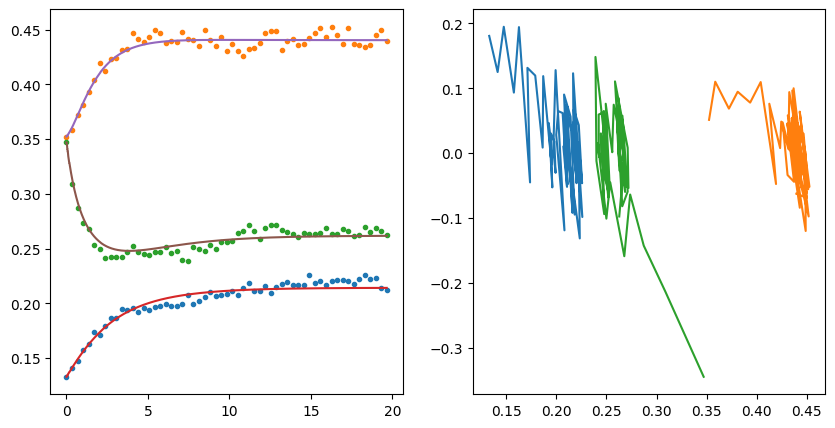

In [68]:
add_log_time_diff(replicates)
add_time_diff(replicates)

t = replicates.dropna()["time"].values
y = replicates.dropna()[[i for i in replicates.columns if i[:2]=="sp"]].values
dydt = replicates.dropna()[[i for i in replicates.columns if i[:3]=="dsp"]].values
dlogydt = replicates.dropna()[[i for i in replicates.columns if i[:6]=="dlogsp"]].values

r_est, A_est = fit_ridge_cv(replicates, "none")
p_est = np.concatenate((r_est, A_est.flatten()))

t_pred = np.arange(t[0], t[-1], dt)
y_pred = euler_maruyama(glv, t[0], y[0], p_est, 0, dt, t_pred)

plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t, y, ".")
plt.plot(t_pred, y_pred)
plt.subplot(1, 2, 2)
plt.plot(y, dlogydt)
plt.show()

In [51]:
A

array([[-1.69003911, -0.56651023,  0.7299756 ],
       [ 0.37299379, -1.74329916, -0.0919733 ],
       [ 1.91382039,  0.33079713, -2.08831669]])

In [39]:
A_est

array([[-1.74213237, -0.433994  ,  0.12334298],
       [ 1.77670942, -3.71973026, -1.56724069],
       [ 2.50125996, -1.23471678, -3.09796598]])

In [114]:
reg = lm.MultiTaskElasticNetCV(alphas=10.**np.arange(-5, 3))
reg.fit(y, dlogydt)
print(reg.intercept_)
print(reg.coef_)

[0.57977372 0.74579755 0.05735448]
[[-1.27990049 -0.72709513  0.06824709]
 [ 0.15388631 -1.52277746 -0.41507259]
 [ 1.20926753  0.39105303 -1.86982421]]


In [105]:
reg = lm.ElasticNetCV(alphas=10.**np.arange(-5, 3), fit_intercept=False)
reg.fit(y[:,[2]]*np.hstack((np.ones((len(y), 1)), y)), dydt[:,2])
print(reg.coef_)

[ 0.07270117  1.19776659  0.31177808 -1.78868887]


/home/valeriano/.virtualenvs/base/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.939499333955337e-05, tolerance: 8.796429353228485e-07
  model = cd_fast.enet_coordinate_descent_gram(
/home/valeriano/.virtualenvs/base/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014658646479885542, tolerance: 2.7601747212543402e-06
  model = cd_fast.enet_coordinate_descent_gram(
/home/valeriano/.virtualenvs/base/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001266492108585671, tolerance: 2.738823900736894e-06
  model = cd_fast.enet_coordinate_descent_gram(
/h

In [56]:
reg = lm.RidgeCV(alphas=10.**np.arange(-8, 6))
reg.fit(y, dlogydt[:,0])
print(reg.intercept_)
print(reg.coef_)

0.5316814821449304
[-1.07737154 -0.73236581  0.10413885]


In [48]:
reg = lm.RidgeCV(alphas=10.**np.arange(-5, 3))
reg.fit(y, dlogydt[:,1])
print(reg.intercept_)
print(reg.coef_)

1.6677633724225447
[ 1.77670942 -3.71973026 -1.56724069]


In [58]:
reg = lm.RidgeCV(alphas=10.**np.arange(-8, 6))
reg.fit(y, dlogydt[:,2])
print(reg.intercept_)
print(reg.coef_)

0.8189865485225178
[ 2.50125996 -1.23471678 -3.09796598]


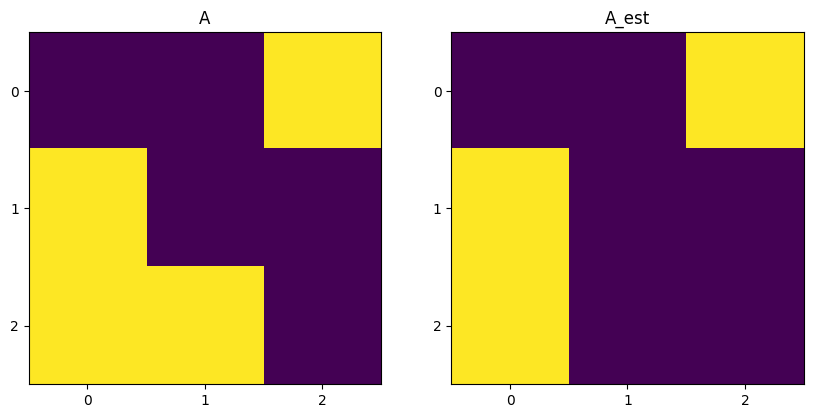

In [41]:
plt.subplots(1, 2, figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.sign(A))
plt.xticks(np.arange(n))
plt.yticks(np.arange(n))
plt.title("A")

plt.subplot(1, 2, 2)
plt.imshow(np.sign(A_est))
plt.xticks(np.arange(n))
plt.yticks(np.arange(n))
plt.title("A_est")
plt.show()